In [17]:
import pandas as pd
%matplotlib inline
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
csvpath = Path('../Resources/high_frequency_euro_ETF_bid_ask_spreads.csv')
df = pd.read_csv(csvpath, parse_dates=True, index_col='timestamp')

df.head()

,bid_ask_spread
timestamp,
2018-12-24 12:32:50.595622+00:00,0.00
2018-12-24 13:00:02.757045+00:00,108.89
2018-12-24 13:00:02.757115+00:00,-0.22
2018-12-24 13:00:13.828698+00:00,-0.21
2018-12-24 13:00:19.347938+00:00,-0.20


In [18]:
# Resample to 10 Seconds ('10S'), take the mean, and drop the NaN values
df = df.resample('10S').mean().dropna()
df.head()

,bid_ask_spread
timestamp,
2018-12-24 12:32:50+00:00,0.000000
2018-12-24 13:00:00+00:00,54.335000
2018-12-24 13:00:10+00:00,-0.205000
2018-12-24 13:00:20+00:00,-0.186667
2018-12-24 13:00:30+00:00,27.080000


## Explaining autocorrelation
The "autocorrelation" is basically the correlation of the time series to the same time series but on a lag of a certain amount of periods. You can see that below

In [19]:
# Autocorrelation with lag of 6

print("Autocorrelation with lag of 1 (using autocorr function w/ lag of 6)\n")
print( str(  df['bid_ask_spread'].autocorr(6)  ) + '\n')

print("Autocorrelation with lag of 1 (using correlation function to same data, just shifted down 6)\n")
print( str(  df['bid_ask_spread'].corr( df['bid_ask_spread'].shift(-6) ) ) + '\n')

print("They're the same!!")

Autocorrelation with lag of 1 (using autocorr function w/ lag of 6)

-0.015722755466084027

Autocorrelation with lag of 1 (using correlation function to same data, just shifted down 6)

-0.015722755466084027

They're the same!!


## A lag vs unlagged time series
This should help make things even clearer

So this time series is on a lag of 6 (you can see by how in the "lagged" variable declaration we shift the data back 6 periods). As a result you'll see that the value of bid_ask_spread at Position 7 equals the value of bid_ask_spread at Position 1. 

Using these two time series (lagged and unlagged), we simply do a correlation between the two--no different from what we did with stock analysis in previous units--and come up with a correlation value (in other words, an r-value). The autocorrelation visualizations we run simply show the correlations of the data at different lags (not just 1 or 2 or 6 periods, but as many as we chose)

In [49]:
# df['bid_ask_spread'].(df['bid_ask_spread'].shift(-6))
correlation_coeff = df['bid_ask_spread'].corr( df['bid_ask_spread'].shift(-6) )
unlagged = df['bid_ask_spread']
lagged = df['bid_ask_spread'].shift(-6).rename('bid_ask_spread_lagged')
position = pd.Series( range(1,len(df['bid_ask_spread'])+1), index = df['bid_ask_spread'].index, name = 'Position' )

print('Correlation coefficient (or "r"): ' + "{:.3f}".format(correlation_coeff) )
pd.concat( [ unlagged , lagged , position ] , axis=1 ).head(10)

Correlation coefficient (or "r"): -0.016


,bid_ask_spread,bid_ask_spread_lagged,Position
timestamp,,,
2018-12-24 12:32:50+00:00,0.000000,-0.205000,1
2018-12-24 13:00:00+00:00,54.335000,-0.190000,2
2018-12-24 13:00:10+00:00,-0.205000,-0.180000,3
2018-12-24 13:00:20+00:00,-0.186667,36.166667,4
2018-12-24 13:00:30+00:00,27.080000,-0.190000,5
2018-12-24 13:00:40+00:00,36.160000,-0.180000,6
2018-12-24 13:00:50+00:00,-0.205000,-0.185000,7
2018-12-24 13:01:10+00:00,-0.190000,-0.185000,8
2018-12-24 13:01:20+00:00,-0.180000,17.990000,9


## So how do we understand those autocorrelation plots?
X-axis: lag, the number of periods the time series has been lagged for correlation with the unlagged time series

Y-axis: correlation, a number from 1 to -1 showing how correlated or uncorrelated the data is to itself on a lag of "x" periods

Confidence interval: the blue margin around the X-axis. It is the range of correlation, outside of which correlation values of lags can be deemed significant in explaining variation in the unlagged time series. 

<u> Understanding the lines </u>

Ok, so look at the below charts. We see that at lag = 1, we have a correlation of maybe ~0.13. This tells us that ~13% of the variation in the time series is related to the variation in the same time series at a lag of 1 period.

Let's do another example. At lag = 3, we have a correlation of around -0.1. This tells us that 1% of the variation in the time series is related to variation *in the opposite direction* in the same time series at a lag of 1 period (because the correlation is negative).

<u> Understanding the blue shading </u>

Basically if it's outside the blue shading (the 95% confidence interval), it's a lag that's worth paying attention to. It has a correlation that is extraordinary and is a relatively good in correlating to the variance of the unlagged time series.

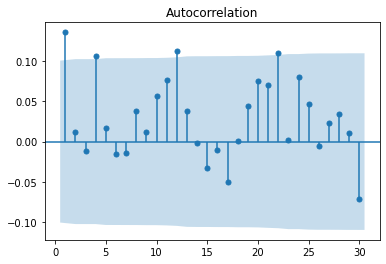

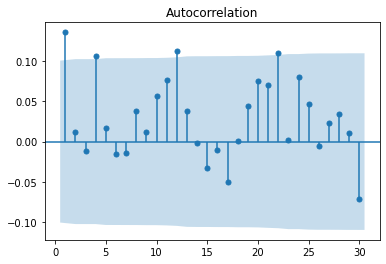

In [20]:
plot_acf(df['bid_ask_spread'], lags=30, zero=False)

Now how does this make sense in the context of bid-ask spreads, you ask? Well here's how. At lag = 12 (or 80 seconds) we've got a correlation of around 0.11 or 11%. This indicates that a high bid-ask spread over the *last 80 seconds* would indicate a high bid-ask spread for the *next 80 seconds*.

### To sum it up, the goal of this autocorrelating is to see what's the best timeframe by which we have to look backwards in order to predict the future by that same timeframe ahead.